In [2]:
#!pip install -U aeon
#!pip install aeon[all_extras]
import warnings
import pandas as pd
from matplotlib import pyplot as plt
from aeon.visualisation import plot_series
from sklearn.metrics import mean_absolute_percentage_error as mape
from all_functions import *
import os
from VotingCombination import VotingCombination
warnings.filterwarnings("ignore")
%matplotlib inline

gasolinac PB normal - {'p': 12, 'd': 1, 'q': 2}
gasolinac PB deseasonal - {'p': 9, 'd': 1, 'q': 9}
gasolinac PB deseasonal-log - {'p': 6, 'd': 1, 'q': 7}
gasolinac PB deseasonal-diff - {'p': 2, 'd': 1, 'q': 9}
gasolinac PB diff - {'p': 13, 'd': 1, 'q': 13}
gasolinac PB log - {'p': 8, 'd': 1, 'q': 10}
gasolinac PB log-diff - {'p': 8, 'd': 1, 'q': 4}


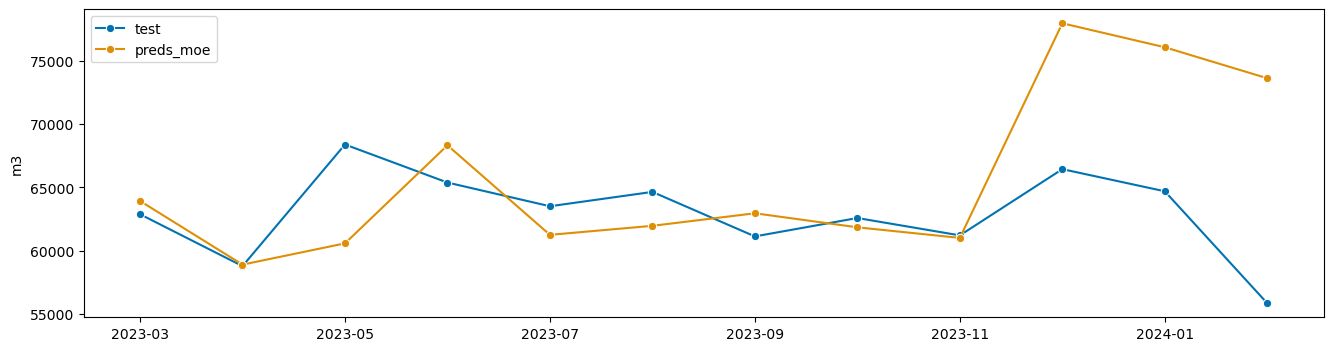

In [2]:
from all_functions import *
import os
import pickle
from sklearn.ensemble import VotingRegressor
from VotingCombination import VotingCombination
import ast
def get_params_csv(path, format):
    df = pd.read_csv(path, sep=";")
    filtered_df = df[df['DATA'] == format]
    return  ast.literal_eval(filtered_df['PARAMS'].iloc[0])

dirs = [
    '../datasets/venda/mensal/uf/gasolinac',
    '../datasets/venda/mensal/uf/etanolhidratado/',
    '../datasets/venda/mensal/uf/gasolinadeaviacao/',
    '../datasets/venda/mensal/uf/glp/',
    '../datasets/venda/mensal/uf/oleocombustivel/',
    '../datasets/venda/mensal/uf/oleodiesel/',
    '../datasets/venda/mensal/uf/querosenedeaviacao/',
    '../datasets/venda/mensal/uf/queroseneiluminante/',
]

results_arima = "./results/arima/rolling"
transformations = ["normal", "deseasonal", "deseasonal-log", "deseasonal-diff", "diff", "log", "log-diff"]
horizon = 12

for directory in dirs:
    for file in os.listdir(directory):
        if file.endswith('.csv'):
            uf = file.split("_")[1].upper()
            derivado = file.split("_")[2].split(".")[0]
            if uf == "PB" and derivado == "gasolinac":
                series = read_series(f"../datasets/venda/mensal/uf/{derivado}/mensal_{uf.lower()}_{derivado}.csv")
                train, test = train_test_stats(series, horizon)
                train_val, test_val = train_test_stats(train, horizon)
                estimators_val = {}
                estimators = {}
                for format in transformations:
                    train_tf_val = transform_train(train_val, format=format)
                    train_tf = transform_train(train, format=format)

                    params = get_params_csv(f"{results_arima}/{derivado}/transform_{uf}.csv", format)
                    print(f'{derivado} {uf} {format} - {params}')
                    initial_order = (params['p'], params['d'], params['q'])

                    #preds validation
                    _, preds_val_real, final_val_order = fit_arima_train(train_tf_val, train_val, initial_order, horizon, format=format)
                    estimators_val[format] = preds_val_real
                    
                    #preds test
                    _, preds_real, final_order = fit_arima_train(train_tf, train, initial_order, horizon, format=format)
                    estimators[format] = preds_real
                
                # print(preds_val_real)
                voting = VotingCombination(estimators, combination='moe')
                voting.fit_moe(estimators_val, test_val)
                preds_moe = voting.predict()
                plot_series(test, preds_moe, labels=["test", "preds_moe"])
                break


In [3]:
voting.get_moe()

[(0, 'diff'),
 (1, 'deseasonal-log'),
 (2, 'normal'),
 (3, 'deseasonal-diff'),
 (4, 'normal'),
 (5, 'normal'),
 (6, 'normal'),
 (7, 'log'),
 (8, 'normal'),
 (9, 'deseasonal-diff'),
 (10, 'deseasonal-diff'),
 (11, 'deseasonal-diff')]

In [5]:
def get_predictions_csv(path, formats, start_index):
    df = pd.read_csv(path, sep=";")
    results = {}
    params = {}
    for format in formats:
        filtered_df = df[df['DATA'] == format]
        
        columns_p1_to_p12 = filtered_df.loc[:, 'P1':'P12']
        
        # values_list = columns_p1_to_p12.values.tolist()
        values_list = columns_p1_to_p12.values.flatten().tolist()        
        results[format] = pd.Series(values_list, index=start_index)
        params[format] = filtered_df['PARAMS'].iloc[0]
            
    return results, params

In [6]:
uf = "PR"
derivado = "gasolinac"
file_path = "./results/arima/rolling/gasolinac/transform_PR.csv"
series = read_series(f"../datasets/venda/mensal/uf/{derivado}/mensal_{uf.lower()}_{derivado}.csv")
_, test = train_test_stats(series, horizon)


predictions, params = get_predictions_csv(file_path, transformations, start_index=test.index)
voting = VotingCombination(predictions, combination='moe')
voting.update_moe([(0,"deseasonal"),(1,"deseasonal"), (2,"deseasonal"), (3,"log"), (4,"log"), (5,"log"), (6,"log"), (7,"log"), (8,"log"), (9,"log"), (10,"log"), (11,"log")])
voting.predict()

timestamp
2023-03    294762.731172
2023-04    287516.940935
2023-05    290341.819788
2023-06    256337.091406
2023-07    277747.979226
2023-08    282123.813436
2023-09    272638.965544
2023-10    262822.154651
2023-11    264372.791480
2023-12    290183.365164
2024-01    256323.800818
2024-02    262214.923920
Freq: M, dtype: float64

In [8]:
results_mean = "./results/arima_sarimads_mean/rolling"
results_median = "./results/arima_sarimads_median/rolling"

horizon = 12
window = 12
arima_results = './results/arima_mean/rolling'
sarima_results = './results/sarima/rolling'
varma_results = './results/varma/rolling'
rf_results = './results/rf/rolling'
# transformations = ["normal", "deseasonal", "log", "deseasonal-log"]

colunas = ['DATA', 'MCPM', 'UF', 'PRODUCT', 'MODEL', 'PARAMS', 'WINDOW', 'HORIZON', 'RMSE', 'MAPE', 'POCID', 'PBE',
           'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12',
           ]
for subdir, _, files in os.walk(arima_results):
    for file in files:
        if file.endswith('.csv'):
            uf = file.split("_")[1][:2]
            derivado = subdir.split("/")[-1]
            file_path = os.path.join(subdir, file)
            series = read_series(f"../datasets/venda/mensal/uf/{derivado}/mensal_{uf.lower()}_{derivado}.csv")
            _, test = train_test_stats(series, horizon)
            predictions = {}

            # preds_arima_mean = pd.read_csv(f"{arima_results}/{derivado}/transform_{uf}.csv", sep=";")
            # preds_arima_mean = preds_arima_mean.loc[:, 'P1':'P12'].values.flatten().tolist() 
            # predictions['arima_mean'] = pd.Series(preds_arima_mean, index=test.index)
            
            preds_sarima = pd.read_csv(f"{sarima_results}/{derivado}/transform_{uf}.csv", sep=";")
            preds_sarima = preds_sarima[preds_sarima['DATA'] == "deseasonal"]
            preds_sarima = preds_sarima.loc[:, 'P1':'P12'].values.flatten().tolist() 
            predictions['sarima'] = pd.Series(preds_sarima, index=test.index)


            preds_varma = pd.read_csv(f"{varma_results}/{derivado}/transform_{uf}.csv", sep=";")
            preds_varma = preds_varma[preds_varma['DATA'] == "normal"]
            preds_varma = preds_varma.loc[:, 'P1':'P12'].values.flatten().tolist() 
            predictions['varma'] = pd.Series(preds_varma, index=test.index)

            # predictions['baseline'] = pd.Series(series[-horizon*2:-horizon].values, index=test.index)
            # preds_rf = pd.read_csv(f"{rf_results}/{derivado}/transform_{uf}.csv", sep=";")
            # preds_rf = preds_rf[preds_rf['DATA'] == "RandomForest"]
            # preds_rf = preds_rf.loc[:, 'P1':'P12'].values.flatten().tolist() 
            # predictions['rf'] = pd.Series(preds_rf, index=test.index)
            
    
            # predictions, params = get_predictions_csv(file_path, transformations, start_index=test.index)
            params = "ARIMA-SARIMA_DS"
            voting = VotingCombination(predictions, combination='mean')
            preds_mean = voting.predict()

            rmse_result = rmse(test, preds_mean)
            mape_result = mape(test, preds_mean)
            pocid_result = pocid(test, preds_mean)
            pbe_result = pbe(test, preds_mean)
            mcpm_result = mcpm(rmse_result, mape_result, pocid_result)

            path_derivado = results_mean + f"/{derivado}"
            csv_file = path_derivado + f"/transform_{uf.upper()}.csv"
            os.makedirs(path_derivado, exist_ok=True)

            df_result = pd.DataFrame({'DATA': "combination", 'MCPM': mcpm_result, 'UF': uf, 'PRODUCT': derivado, 'MODEL': 'combination-mean', 'PARAMS': params, 'WINDOW': window, 'HORIZON': horizon,  
                                            'RMSE': rmse_result, 'MAPE': mape_result, 'POCID': pocid_result, 'PBE': pbe_result,
                                            'P1': preds_mean[0], 'P2': preds_mean[1], 'P3': preds_mean[2], 'P4': preds_mean[3], 'P5': preds_mean[4],
                                            'P6': preds_mean[5], 'P7': preds_mean[6], 'P8': preds_mean[7], 'P9': preds_mean[8], 'P10': preds_mean[9],
                                            'P11': preds_mean[10], 'P12': preds_mean[11]
                                            }, index=[0])
            df_result = df_result[colunas]

            df_result.to_csv(csv_file, sep=';', index=False)


            #MEDIAN
            voting = VotingCombination(predictions, combination='median')
            preds_mean = voting.predict()

            rmse_result = rmse(test, preds_mean)
            mape_result = mape(test, preds_mean)
            pocid_result = pocid(test, preds_mean)
            pbe_result = pbe(test, preds_mean)
            mcpm_result = mcpm(rmse_result, mape_result, pocid_result)

            path_derivado = results_median + f"/{derivado}"
            csv_file = path_derivado + f"/transform_{uf.upper()}.csv"
            os.makedirs(path_derivado, exist_ok=True)
            df_result = pd.DataFrame({'DATA': "combination", 'MCPM': mcpm_result, 'UF': uf, 'PRODUCT': derivado, 'MODEL': 'combination-median', 'PARAMS': params, 'WINDOW': window, 'HORIZON': horizon,  
                                            'RMSE': rmse_result, 'MAPE': mape_result, 'POCID': pocid_result, 'PBE': pbe_result,
                                            'P1': preds_mean[0], 'P2': preds_mean[1], 'P3': preds_mean[2], 'P4': preds_mean[3], 'P5': preds_mean[4],
                                            'P6': preds_mean[5], 'P7': preds_mean[6], 'P8': preds_mean[7], 'P9': preds_mean[8], 'P10': preds_mean[9],
                                            'P11': preds_mean[10], 'P12': preds_mean[11]
                                            }, index=[0])
            df_result = df_result[colunas]

            df_result.to_csv(csv_file, sep=';', index=False)


In [46]:
# results_mean = "./results/sarima_mean/rolling"
# results_median = "./results/sarima_median/rolling"
# horizon = 12
# window = 12
# sarima_results = './results/sarima/rolling'
# transformations = ["normal", "deseasonal", "log", "deseasonal-log"]

# colunas = ['DATA', 'MCPM', 'UF', 'PRODUCT', 'MODEL', 'PARAMS', 'WINDOW', 'HORIZON', 'RMSE', 'MAPE', 'POCID', 'PBE',
#            'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12',
#            ]
# for subdir, _, files in os.walk(sarima_results):
#     for file in files:
#         if file.endswith('.csv'):
#             uf = file.split("_")[1][:2]
#             derivado = subdir.split("/")[-1]
#             file_path = os.path.join(subdir, file)
#             series = read_series(f"../datasets/venda/mensal/uf/{derivado}/mensal_{uf.lower()}_{derivado}.csv")
#             _, test = train_test_stats(series, horizon)
            

#             predictions, params = get_predictions_csv(file_path, transformations, start_index=test.index)
            
#             voting = VotingCombination(predictions, combination='mean')
#             preds_mean = voting.predict()

#             rmse_result = rmse(test, preds_mean)
#             mape_result = mape(test, preds_mean)
#             pocid_result = pocid(test, preds_mean)
#             pbe_result = pbe(test, preds_mean)
#             mcpm_result = mcpm(rmse_result, mape_result, pocid_result)

#             path_derivado = results_mean + f"/{derivado}"
#             csv_file = path_derivado + f"/transform_{uf.upper()}.csv"
#             os.makedirs(path_derivado, exist_ok=True)

#             df_result = pd.DataFrame({'DATA': "combination", 'MCPM': mcpm_result, 'UF': uf, 'PRODUCT': derivado, 'MODEL': 'ARIMA-MEAN', 'PARAMS': params, 'WINDOW': window, 'HORIZON': horizon,  
#                                             'RMSE': rmse_result, 'MAPE': mape_result, 'POCID': pocid_result, 'PBE': pbe_result,
#                                             'P1': preds_mean[0], 'P2': preds_mean[1], 'P3': preds_mean[2], 'P4': preds_mean[3], 'P5': preds_mean[4],
#                                             'P6': preds_mean[5], 'P7': preds_mean[6], 'P8': preds_mean[7], 'P9': preds_mean[8], 'P10': preds_mean[9],
#                                             'P11': preds_mean[10], 'P12': preds_mean[11]
#                                             }, index=[0])
#             df_result = df_result[colunas]

#             df_result.to_csv(csv_file, sep=';', index=False)


#             #MEDIAN
#             voting = VotingCombination(predictions, combination='median')
#             preds_mean = voting.predict()

#             rmse_result = rmse(test, preds_mean)
#             mape_result = mape(test, preds_mean)
#             pocid_result = pocid(test, preds_mean)
#             pbe_result = pbe(test, preds_mean)
#             mcpm_result = mcpm(rmse_result, mape_result, pocid_result)

#             path_derivado = results_median + f"/{derivado}"
#             csv_file = path_derivado + f"/transform_{uf.upper()}.csv"
#             os.makedirs(path_derivado, exist_ok=True)
#             df_result = pd.DataFrame({'DATA': "combination", 'MCPM': mcpm_result, 'UF': uf, 'PRODUCT': derivado, 'MODEL': 'SARIMA_MEDIAN', 'PARAMS': str(params), 'WINDOW': window, 'HORIZON': horizon,  
#                                             'RMSE': rmse_result, 'MAPE': mape_result, 'POCID': pocid_result, 'PBE': pbe_result,
#                                             'P1': preds_mean[0], 'P2': preds_mean[1], 'P3': preds_mean[2], 'P4': preds_mean[3], 'P5': preds_mean[4],
#                                             'P6': preds_mean[5], 'P7': preds_mean[6], 'P8': preds_mean[7], 'P9': preds_mean[8], 'P10': preds_mean[9],
#                                             'P11': preds_mean[10], 'P12': preds_mean[11]
#                                             }, index=[0])
#             df_result = df_result[colunas]

#             df_result.to_csv(csv_file, sep=';', index=False)

In [8]:
dt = pd.read_csv("./results/arima/rolling/gasolinac/transform_PR.csv", sep=";")
filtered_df = dt[dt['DATA'] == "normal"]
preds_normal = filtered_df.loc[:, 'P1':'P12'].values.flatten().tolist()
preds_normal


dt = pd.read_csv("./results/arima/rolling/gasolinac/transform_PR.csv", sep=";")
filtered_df = dt[dt['DATA'] == "log"]
preds_log = filtered_df.loc[:, 'P1':'P12'].values.flatten().tolist()
preds_log

dt = pd.read_csv("./results/arima/rolling/gasolinac/transform_PR.csv", sep=";")
filtered_df = dt[dt['DATA'] == "deseasonal"]
preds_deseasonal = filtered_df.loc[:, 'P1':'P12'].values.flatten().tolist()
preds_deseasonal

dt = pd.read_csv("./results/arima/rolling/gasolinac/transform_PR.csv", sep=";")
filtered_df = dt[dt['DATA'] == "deseasonal-log"]
preds_deseasonal_log = filtered_df.loc[:, 'P1':'P12'].values.flatten().tolist()
preds_deseasonal_log

dt = pd.read_csv("./results/arima_mean/rolling/gasolinac/transform_PR.csv", sep=";")
filtered_df = dt[dt['DATA'] == "arima-mean"]
preds_arima_mean = filtered_df.loc[:, 'P1':'P12'].values.flatten().tolist()
preds_arima_mean

dt = pd.read_csv("./results/arima_median/rolling/gasolinac/transform_PR.csv", sep=";")
filtered_df = dt[dt['DATA'] == "arima-median"]
preds_arima_median = filtered_df.loc[:, 'P1':'P12'].values.flatten().tolist()
preds_arima_median

dt = pd.read_csv("./results/varma/rolling/gasolinac/transform_PR.csv", sep=";")
filtered_df = dt[dt['DATA'] == "normal"]
preds_varma = filtered_df.loc[:, 'P1':'P12'].values.flatten().tolist()
preds_varma


series = read_series(f"../datasets/venda/mensal/uf/gasolinac/mensal_pr_gasolinac.csv")
_, test = train_test_stats(series, horizon)
            

In [9]:
test.tolist()

[282733.246,
 278030.363,
 308678.848,
 282389.703,
 280493.13,
 285714.356,
 268792.424,
 262763.72,
 262554.957,
 306762.262,
 261165.719,
 233943.837]

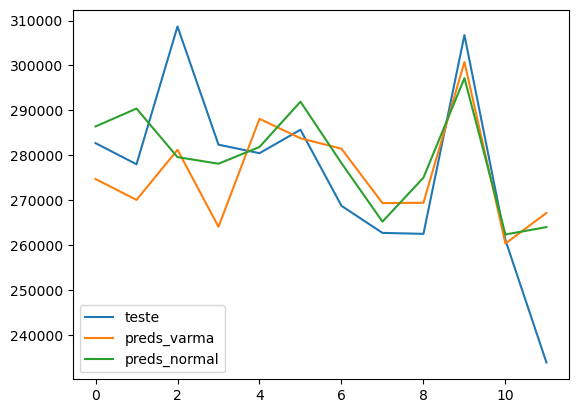

In [10]:

listas = [test.tolist(), preds_varma,
            preds_normal,
        #  preds_log, preds_deseasonal, preds_deseasonal_log, preds_arima_mean, preds_arima_median
          ]

names = ["teste", "preds_varma",
         "preds_normal",
        #  "preds_log", "preds_deseasonal", "preds_deseasonal_log", "preds_arima_mean", "preds_arima_median"
         ]
for i in range(len(listas)):
    plt.plot(listas[i], label=names[i])
    plt.legend()

In [11]:
def euclidean_dist(serie1, serie2):
    dist = np.linalg.norm(serie1 - serie2)
    return dist

In [12]:
euclidean_dist(preds_normal, test)

48192.93906005725

In [13]:
"../datasets/venda/mensal/uf/abc".split("/")[-1]

'abc'

In [14]:
import os
import pandas as pd
import numpy as np

path_datasets = '../datasets/venda/mensal/uf'

def build_state_matrix(states):
    n = len(states)
    matrix = pd.DataFrame(np.zeros((n, n)), index=states, columns=states)
    return matrix

def make_matrix(path_derivado):
        # derivado = path_derivado.split("/")[-1]
                
        csv_files = [file for file in os.listdir(path_derivado) if file.endswith('.csv')]
        
        states = []
        for csv_file in csv_files:  
            start = csv_file.find('mensal_') + len('mensal_')
            end = csv_file.find('_', start)
            state = csv_file[start:end].upper()
            
            states.append(state)
                
        return build_state_matrix(states)


def euclidean_series(matrix, path_derivado, transform):
    derivado = path_derivado.split("/")[-1]
    for row in matrix.itertuples():
        row_header = row.Index
        for col_header in matrix.columns:
            if row_header != col_header:
                series_row = read_series(f"{path_derivado}/mensal_{row_header.lower()}_{derivado}.csv")
                series_col = read_series(f"{path_derivado}/mensal_{col_header.lower()}_{derivado}.csv")
                train_row, _ = train_test_stats(series_row, horizon)
                train_col, _ = train_test_stats(series_col, horizon)
                train_tf_row = transform_train(train_row, format=transform)
                train_tf_col = transform_train(train_col, format=transform)
                matrix.at[row_header, col_header] = euclidean_dist(train_tf_row, train_tf_col)

    return matrix

def similar_states(matrix, x, estado):
    filtered_values = matrix[estado].copy()
    filtered_values[matrix.index == estado] = np.nan
    
    # Obtém os X menores valores
    smallest_values = filtered_values.nsmallest(x)
    
    return smallest_values

        

In [15]:
derivado = "gasolinac"
path_derivado = path_datasets+"/"+derivado
matrix = make_matrix(path_derivado)
matrix_euclid = euclidean_series(matrix, path_derivado, "normal")

In [29]:
euclidean_states = similar_states(matrix_euclid, 3, "PR").keys().tolist()
euclidean_states

['SP', 'MG', 'MS']

In [17]:
#teste
train_dict = {}
test_dict = {}
train_tf_dict = {}

for transform in ["normal"]:
    for file in os.listdir(path_derivado):
        if file.endswith('.csv'):
            full_path = os.path.join(path_derivado, file)
            uf = file.split("_")[1].upper()
            series = read_series(full_path)
            #teste
            train, test = train_test_stats(series, horizon)
            train_tf = transform_train(train, format=transform)
            train_tf_dict[uf] = train_tf
            test_dict[uf] = test
            train_dict[uf] = train


    #teste
    df_train_tf = pd.DataFrame(train_tf_dict)
    df_test = pd.DataFrame(test_dict)
    df_train = pd.DataFrame(train_dict)
        

In [20]:
df_train_tf[euclidean_states]

,SP,MG,MS,GO,RS
timestamp,,,,,
1990-01,1.203208,0.546072,0.743983,1.022810,1.641827
1990-02,-0.252965,-0.819552,-0.594463,-0.861750,-1.619537
1990-03,-1.225920,-1.269055,-1.479201,-1.696071,0.064911
1990-04,0.586803,1.112056,0.501140,0.234759,0.979251
1990-05,-0.153363,-0.202495,-0.517300,-0.605250,0.002942
...,...,...,...,...,...
2022-10,0.570860,0.703490,0.815746,0.547519,0.619786
2022-11,0.448307,0.399364,0.410382,0.563845,0.361081
2022-12,2.744097,1.979377,2.283397,1.872494,2.624960


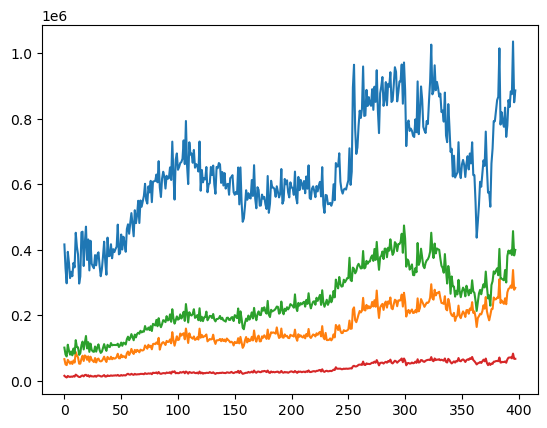

In [35]:
plt.plot(df_train["SP"].tolist())
plt.plot(df_train["PR"].tolist())
plt.plot(df_train["MG"].tolist())
plt.plot(df_train["MS"].tolist())
# plt.plot(df_train["AC"].tolist())